In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickSoc: No module named 'pynq'


c:\Users\slab\anaconda3\lib\site-packages\visa.py:13: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  warnings.warn(


Warning serial library import failed.


c:\Users\slab\anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [2]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# State tomography analysis functions

Measurement occurs along 3 axes, each of which can give one of 2 values:

Z, X, Y -> {0, 1}

In [3]:
meas_order = np.array(['Z', 'X', 'Y'])
calib_order = np.array(['g', 'e'])

## Getting rho from meas counts

First random helper method stuff for pauli matrices and dealing with the measurement order

In [4]:
def pauli(i): return [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()][i]

def s2i(s): # string to pauli matrix index
    return int(np.char.find('IXYZ', s))

def i2s(i): # pauli matrix index to string
    return 'IXYZ'[i]

def order(S): # given a pauli matrix name, get the index at which it (or equivalent data) was measured
    assert S in 'IXYZ'
    # for the purposes of getting counts, measuring in I basis and Z basis are interchangeable
    if S == 'I': S = 'Z'
    return np.argwhere(meas_order == S)[0][0]
# print(order('X'))

In [5]:
"""
Define basis in to be used when doing MLE
"""
# 2 cardinal points on Bloch sphere for each measurement axis
# psiZ = [qt.basis(3,0), qt.basis(3,1)]
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi = dict(Z=psiZ, X=psiX, Y=psiY)

psi_basis = dict() # 6 elements
# psi_tensor = [psiZ[0], psiZ[0], psiZ[0], psiZ[0]]
for S in meas_order:
    psi0 = psi[S]
    psi_basis.update({S:[]})

    psi_basis[S].append(psi0[0]) # g
    psi_basis[S].append(psi0[1]) # e

Convert single shot measurements into counts for each of the 9 measurement axes: 4x9=36 elements in the count array, then into the initial rho from experiment which will likely be unphysical.

In [6]:
"""
n should be length 2 array containing single shot counts of measuring 0, 1 for measurement along axes i, j
Converts n to Tij for use in the T^\dag T = rho matrix where measurement axes are S: I, X, Y, Z
"""
def Tij(n, S):
    assert 0 <= S <= 3 # S1, S2 represent pauli matrix indices
    signs = [1]*2
    # eigenvalues of X, Y, Z are +/- 1, eigenvalues of I are +1
    if S > 0: signs[1] *= -1
    return np.sum(np.multiply(signs, n))


In [7]:
"""
Construct rho by adding together Tij for each of the 4 Pauli matrices
"""
def rho_from_counts(n):
    rho = 0*qt.qeye(2)
    for i in range(4): # loop over pauli matrices for qubit 1
        o = order(i2s(i)) # get the right 2 elements in the n matrix
        rho += Tij(n[2*o:2*(o+1)], i) * pauli(i)
    rho = rho.unit() # normalize
    rho = rho.tidyup(1e-10) # remove small elements
    rho = rho.full()
    return rho

### Generate test data

In [8]:
def generate_counts(qubits, rho_id, n_tot, noise=1.0):
    n = []
    for S in meas_order:
        for psi0 in psi_basis[S]:
            # measure in psi basis
            n.append(n_tot * (psi0 * psi0.dag() * rho_id).tr())
    n = np.reshape(np.array(n), (len(psi_basis.keys()), 4))

    # introduce gaussian noise
    for n_psi in n:
        n_meas = sum(n_psi)
        new_n1 = -1
        while new_n1 < 0:
            new_n0 = np.random.normal(loc=n_psi[0], scale=noise*np.sqrt(n_psi[0]))
            # preserve original total count per measurement
            new_n1 = n_meas - sum(new_n0)
        n_psi[0] = np.round(new_n0)
        n_psi[1] = np.round(new_n1)
    return n

### Error mitigation
Readout error means state prepared in |gg> will also have counts in |ge>, |eg>, |ee>; apply inverse of confusion matrix to correct. See qiskit measurement error mitigation procedure: [https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html](https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html)

maybe need to do something about fixing negative counts, but for now I will not. it should be automatically resolved in the MLE.

In [9]:
def correct_readout_err(n, n_conf):
    conf_mat = np.array(n_conf, dtype=float)
    for r, row in enumerate(conf_mat):
        conf_mat[r] /= sum(row) # normalize so counts for each state prep sum to 1
    conf_mat = np.transpose(conf_mat) # want counts for each state prep on columns
    conf_mat_inv = np.linalg.inv(conf_mat)
    # C_id = invM . C_noisy
    n = np.array(n, dtype=float)
    for r in range(len(n)):
        n[r] = (conf_mat_inv @ n[r].T).T
    return np.around(n, decimals=5)

In [10]:
def fix_neg_counts(counts):
    counts = np.array(counts)
    assert len(counts.shape) == 2 # 2d array

    for i_n, n in enumerate(counts):
        while len(n[n<0]) > 0: # repeat while still has neg counts
            assert sum(n) > 0, 'Negative sum of counts'
            neg_indices = np.where(n<0)[0]
            neg_vals = n[n<0]
            len_pos = len(n) - len(neg_vals)
            n += sum(neg_vals)/len_pos # redistribute the negative counts over all the positive elements evenly
            for i in neg_indices:
                n[i] = 0

        counts[i_n] = np.round(n)
    return counts

## Fix rho to a physical density matrix using MLE
Initial counts will be unphysical. Use MLE to map counts to a physical density matrix.

### Cholesky-esque decomposition functions

In [11]:
# Modification of np.diag_indices to allow off diagonal entries
# n = dim, k < 0 = lower diagonals, k > 0 = upper diagonals
def diag_indices_k(a, k):
    rows, cols = np.diag_indices_from(a)
    if k < 0: return rows[-k:], cols[:k]
    elif k > 0: return rows[:-k], cols[k:]
    else: return rows, cols

def T_flat2mat(t):
    # T_mat = []
    # T_mat.appen(np.array([t[0],           0,              0,               0]))
    # T_mat.append(np.array([t[4] +1j*t[5],  t[1],           0,               0]))
    # T_mat.append(np.array([t[10]+1j*t[11], t[6]+1j*t[7],   t[2],            0]))
    # T_mat.append(np.array([t[14]+1j*t[15], t[12]+1j*t[13], t[8]+1j*t[9], t[3]]))
    d = int(np.sqrt(len(t)))
    t_complex = np.zeros(int(d + (len(t)-d)/2), dtype=complex)
    t_complex[:d] = t[:d]
    for i in range(d, len(t_complex)):
        t_complex[i] = t[d + (i-d)*2] + 1j*t[d + (i-d)*2 + 1]
    T_mat = np.zeros(shape=(d,d), dtype=complex)
    start_i = 0
    for k in range(d):
        T_mat[diag_indices_k(T_mat, -k)] = t_complex[start_i:start_i+(d-k)]
        start_i += d - k
    return np.array(T_mat)


Not using these!


This is taken from [James et al. 2001](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.64.052312), eq. 4.6.

In [12]:
# def det_ij(rho, i, j):
#     M = np.delete(rho, i, axis=0)
#     M = np.delete(M, j, axis=1)
#     return np.linalg.det(M)

# def det_ijkl(rho, i, j, k, l):
#     M = np.delete(rho, [i,k], axis=0)
#     M = np.delete(M, [j,l], axis=1)
#     return np.linalg.det(M)

# def t_from_rho_unused(rho):
#     t = []
#     det = np.linalg.det(rho)
#     det00 = det_ij(rho, 0, 0)
#     det01 = det_ij(rho, 0, 1)
#     det0011 = det_ijkl(rho, 0, 0, 1, 1)
#     det0012 = det_ijkl(rho, 0, 0, 1, 2)
#     det0112 = det_ijkl(rho, 0, 1, 1, 2)
#     # ensure no divide by 0 errors since this algo is intended for positive definite matrices
#     if det == 0: det = 1e-10
#     if det00 == 0: det00 = 1e-10
#     if det0011 == 0: det0011 = 1e-10
#     if det0012 == 0: det0012 = 1e-10
#     if det0112 == 0: det0112 = 1e-10
#     rho33 = rho[3,3]
#     if rho33 == 0: rho33 = 1e-10
#     t = [np.sqrt(det/det00), np.sqrt(det00/det0011), np.sqrt(det0011/rho33), np.sqrt(rho[3,3])]
#     t56 = det01/np.sqrt(det00*det0011)
#     t.extend([np.real(t56), np.imag(t56)])
#     t78 = det0012/np.sqrt(rho33*det0011)
#     t.extend([np.real(t78), np.imag(t78)])
#     t910 = rho[3,2]/np.sqrt(rho33)
#     t.extend([np.real(t910), np.imag(t910)])
#     t1112 = det0112/np.sqrt(rho33*det0011)
#     t.extend([np.real(t1112), np.imag(t1112)])
#     t1314 = rho[3,1]/np.sqrt(rho33)
#     t.extend([np.real(t1314), np.imag(t1314)])
#     t1516 = rho[3,0]/np.sqrt(rho33)
#     t.extend([np.real(t1516), np.imag(t1516)])
#     assert(len(t)==16)
#     return np.real(np.array(t)) # take the real since rho may be slightly non-positive semi definite, so det(rho) may be slightly negative

# def rho_from_t_unused(t):
#     T = T_flat2mat(t)
#     rho = T.conj().T @ T
#     return rho / np.trace(rho)

Using this.

Cholesky-Banachiewicz algorithm - valid for positive definite matrices, so need to ensure no divide by 0 errors. I think this actually works better than the James et al method?

In [13]:
def t_from_rho(rho):
    t = []
    T = np.zeros(shape=np.shape(rho))
    d = np.shape(rho)[0]
    for i in range(d):
        for j in range(i+1):
            sum = 0
            for k in range(j):
                sum += T[i, k] * T[j, k]
            if i == j: T[i, i] = np.sqrt(rho[i, i] - sum)
            else:
                Tjj = T[j, j]
                if Tjj == 0: Tjj = 1e-10
                T[i, j] = (rho[i, j] - sum) / Tjj
    t = np.diagonal(T)
    for k in range(1, d):
        t_complex = np.diag(T, k=-k)
        for t_i in t_complex:
            t = np.append(t, [np.real(t_i), np.imag(t_i)])
    return np.real(t)
    
def rho_from_t(t):
    T = T_flat2mat(t)
    rho = T @ T.conj().T
    return rho / np.trace(rho)

### MLE functions

In [14]:
def run_MLE(n, rho_guess=None, method='L-BFGS-B', decimals=10):
    # methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
    if rho_guess is None: rho_guess = rho_from_counts(n)
    n_tot = sum(n)
    # psi_basis = get_psi_basis(qubits)
    psi_basis_flat = []
    for S in meas_order:
        for psi in psi_basis[S]:
            # measure in psi basis
            psi_basis_flat.append(psi)
    def likelihood(t_arr):
        rho = rho_from_t(t_arr)
        rho = rho / np.trace(rho)
        val = 0
        for psi, n_val in zip(psi_basis_flat, n.flatten()):
            psi = psi.full()
            proj = (psi.conj().T @ rho @ psi)[0][0]
            if proj != 0:
                val += np.real(abs(n_tot * proj - n_val)**2 / (n_tot * proj))
        return np.log(val)
    optvals = sp.optimize.minimize(likelihood, t_from_rho(rho_guess), method=method)
    print(f'Convergence: {optvals.success}')
    return np.around(rho_from_t(optvals.x), decimals=decimals)

# Plotting functions

In [15]:
def show_mat_2d(mat, ax, title, labels, cmax=None, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    plt.xticks(np.arange(len(mat)), labels)
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-1, vmax=1)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_MLE, rho_id=None, title=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    labels = ["0", "1"]
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title)
    show_mat_2d(np.real(rho_MLE), ax=ax1, title="Re[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_MLE), ax=ax2, title="Im[$\\rho_{MLE}$]", labels=labels, show=False)
    show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, show=False)
    show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, show=False)
    plt.show()

In [16]:
# Author: Ziqian
def show_plot_rho_3d(rho_MLE, rho_id=None):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221, projection='3d')
        ax2 = fig.add_subplot(222, projection='3d')
        ax3 = fig.add_subplot(223, projection='3d')
        ax4 = fig.add_subplot(224, projection='3d')
    
    labels = ["0", "1"]
    qplt.matrix_histogram(np.real(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax1)
    qplt.matrix_histogram(np.imag(rho_MLE), labels, labels, limits=[-0.5,0.5], ax=ax2)
    if rho_id is not None:
        qplt.matrix_histogram(np.real(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax3)
        qplt.matrix_histogram(np.imag(rho_id), labels, labels, limits=[-0.5,0.5], ax=ax4)
    
    ax1.view_init(azim=-55, elev=45)
    ax2.view_init(azim=-55, elev=45)
    ax1.set_title("Re[$\\rho_{MLE}$]")
    ax2.set_title("Im[$\\rho_{MLE}$]")
    if rho_id is not None:
        ax3.view_init(azim=-55, elev=45)
        ax4.view_init(azim=-55, elev=45)
        ax3.set_title("Re[$\\rho_{ideal}$]")
        ax4.set_title("Im[$\\rho_{ideal}$]")
    plt.show()

# Run experiment and analysis

In [17]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
imported experiments.two_qubit.pulse_probe_EgGf_spectroscopy
imported experiments.two_qubit.randbench
imported experiments.two_qubit.twoqutrit_state_tomogr

In [18]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [19]:
# expt_path = os.getcwd()+'\data'
# expt_path = 's:\\Connie\\experiments\\20220430_2Transmon\\data'
# expt_path = os.getcwd()+'\\data_220712'
expt_path=os.getcwd()+'\data\data_221215'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_221215


In [20]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file

# config_file = 'config.yml'
# config_path = 's:\\Connie\\experiments\\20220430_2Transmon\\' + config_file

print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


In [21]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

## Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [22]:
im = InstrumentManager()

In [27]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

0

In [23]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

## Run experiment and acquire data

In [131]:
qubit = 1 # which qubit/resonator we want to probe

{'device': {'qubit': {'T1': [30, 96, 9, 58], 'f_ge': [146.3200507751049, 3464.1798421793665, 808.0847336808625, 420.4349909806926], 'f_Q1_ZZ': [3459.6967629797664, 0, 3463.7374335056006, 3463.5464893503636], 'f_ef': [-78.90376315971923, 3364.253, 611.098326885819, 275.76433968698353], 'f_EgGf': [2678.7, 0, 2010.8, 2395.5], 'ZZs': [0.0, -4.7126775455997745, -0.10534620937775685, -0.28344964409794215, -4.236078028296106, 0.0, -0.16869289545775246, -0.2784781391173965, 0.5146242128746508, -0.12676679271078228, 0.0, -0.06125637291711428, 3.0556426555347116, 2.6356995614617063, 3.312733462014023, 0.0], 'pulses': {'pi_ge': {'gain': [24653, 20197, 27992, 28755], 'sigma': [0.0403, 0.02, 0.04, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [31065, 13553, 16026, 29402], 'sigma': [0.025, 0.025, 0.025, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [27345, 0, 27988, 29136], 'sigma': [0.015, 0, 0.015, 0.015], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gai

  0%|          | 0/2 [00:00<?, ?it/s]

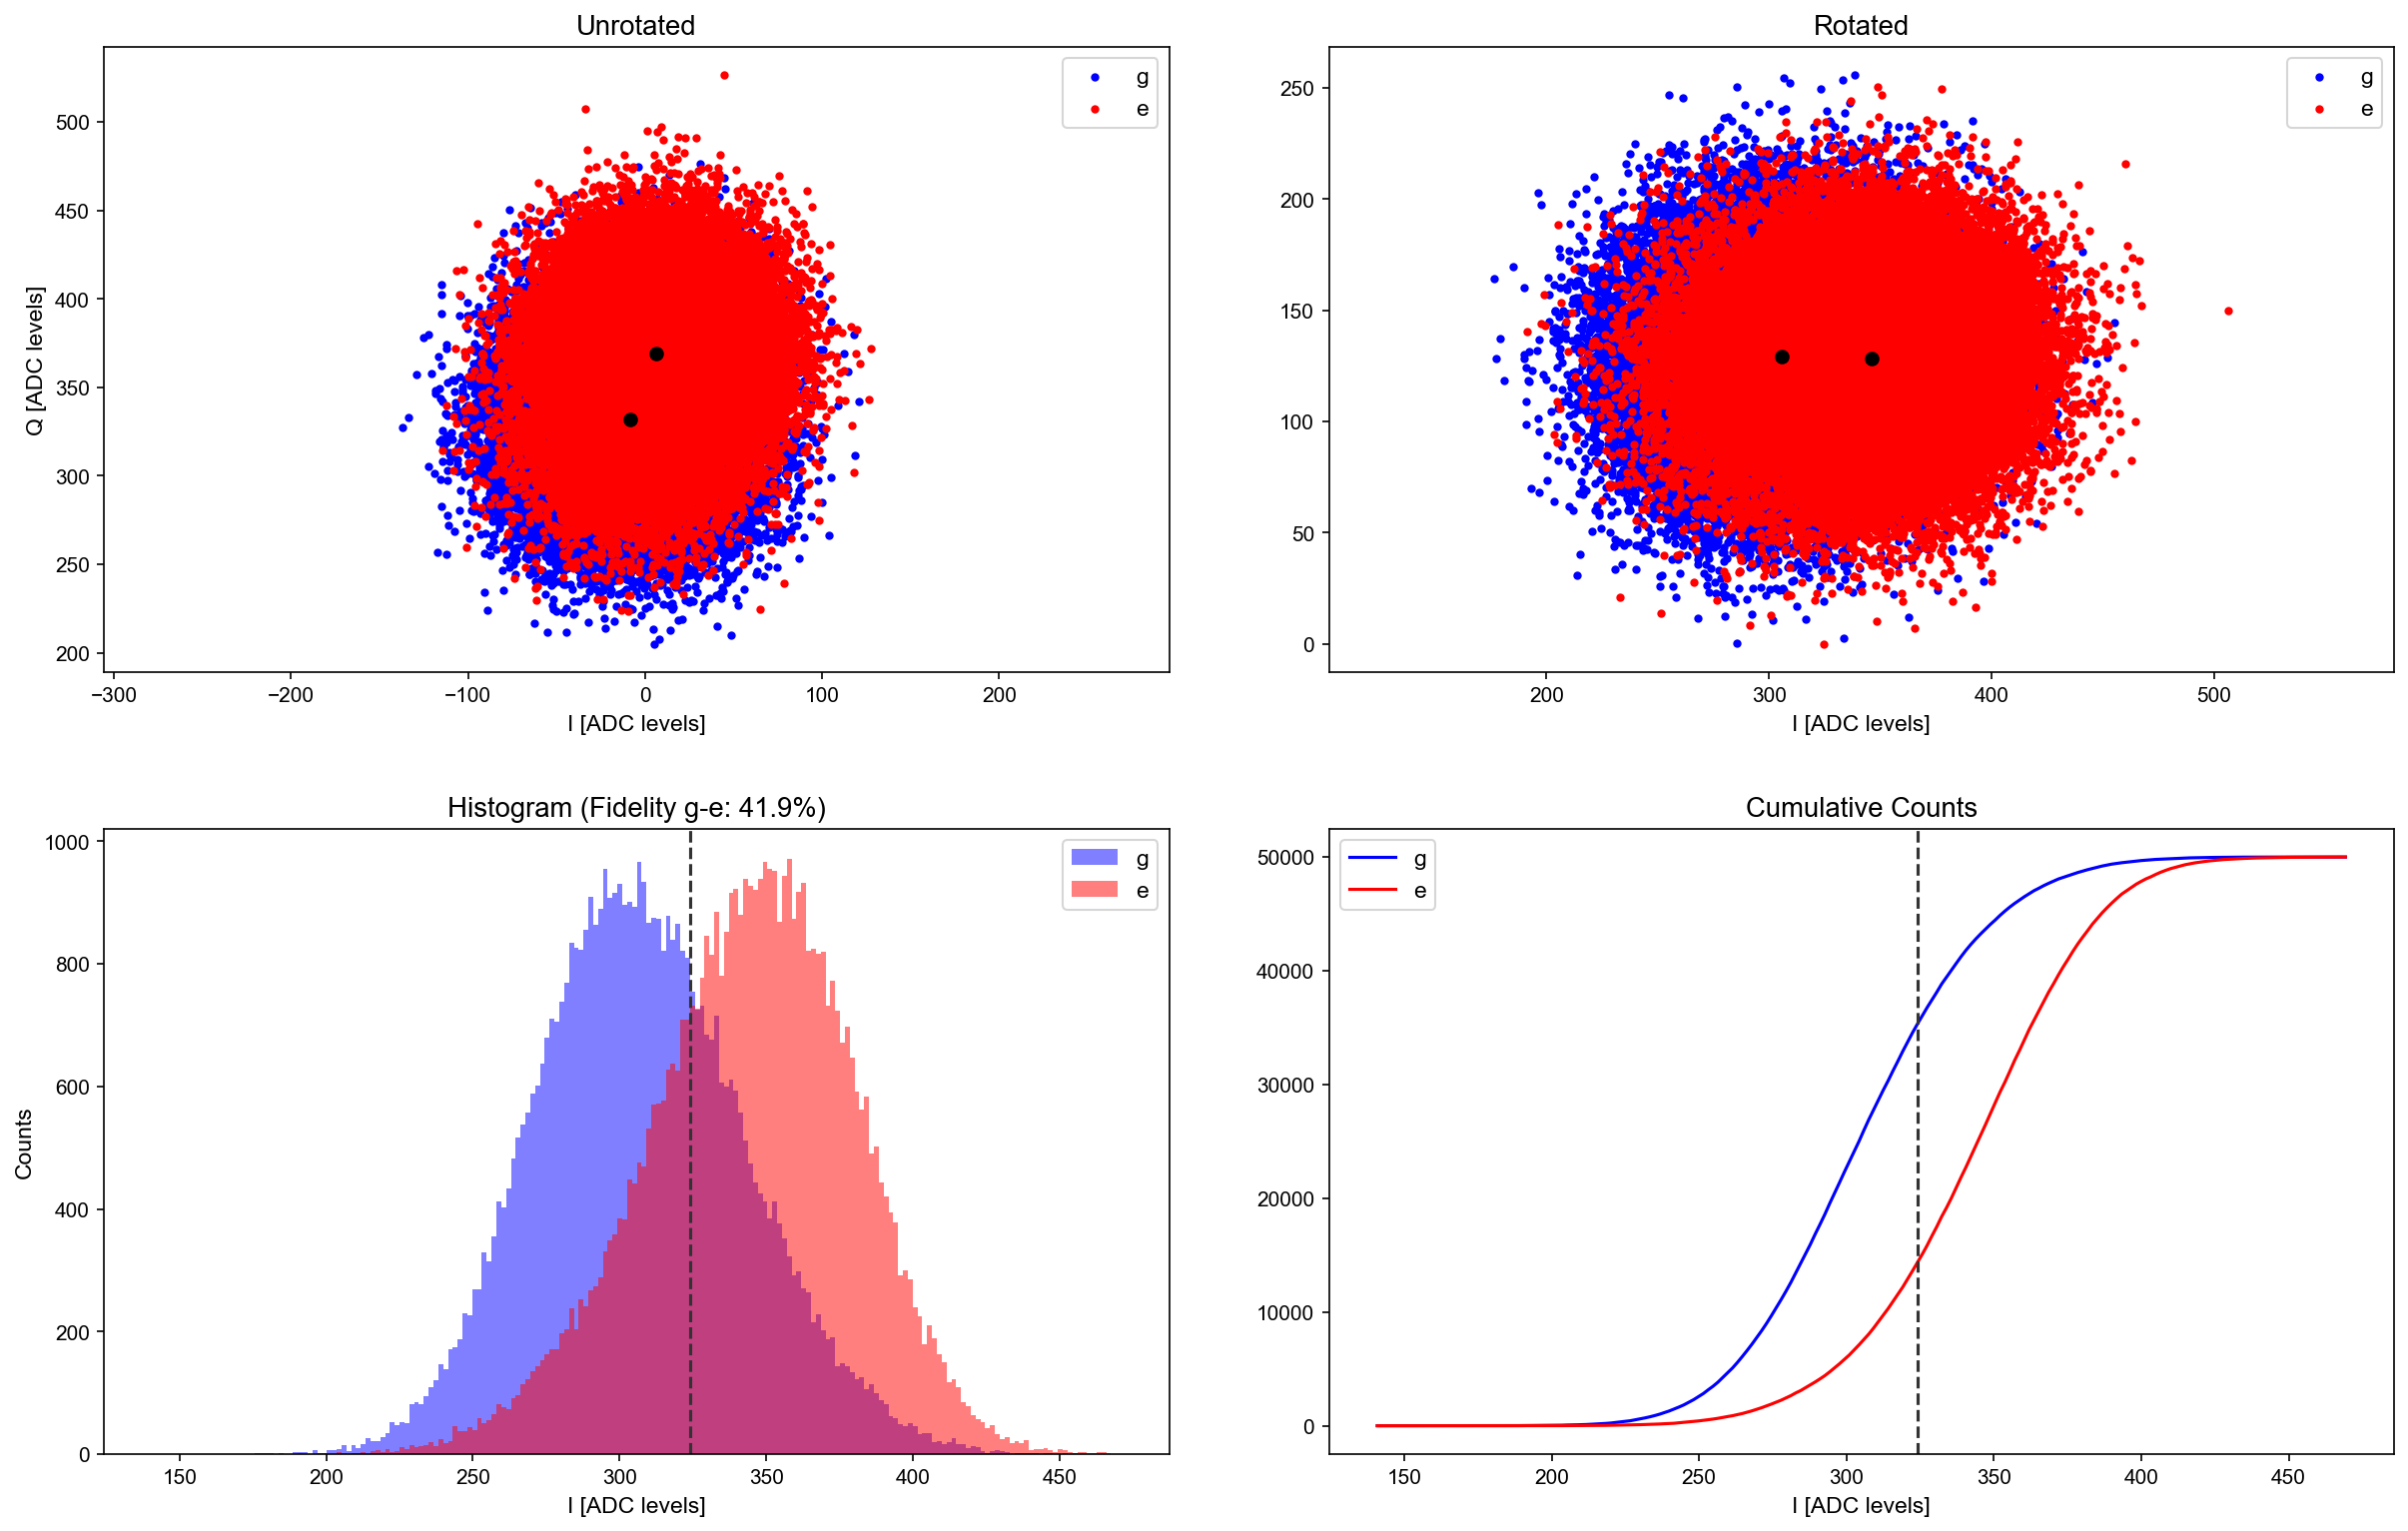

thresholds [0, [324.0233246061096], 0, 0]
angles [0, -68.6597672026124, 0, 0]
[-555.6745850959974, 305.8707328339241, -15.621054344288968, 844.383826879271]
[-556.9450048812236, 346.20161213868744, -14.401887406443215, 837.7367393426618]


  0%|          | 0/3 [00:00<?, ?it/s]

[-558.0120403514481, 325.70641640192486, -14.598112593556785, 841.8955418158151]
[-558.1820696387895, 334.1200891459731, -14.230231044581842, 844.5356329319883]
[-557.7849007484542, 344.1738897362082, -14.961763748779694, 834.6931337455255]


In [132]:
tomo = meas.StateTomography1QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"StateTomoQ{qubit}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=50000, # reps per measurement basis
    qubit=qubit,
)

print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

## Run analysis

In [133]:
tomo = tomo
# tomo = qramExpt

# data, attrs = prev_data(expt_path, '00000_EgGf_state_tomo_01.h5')
# pulse_dict = attrs['pulse_dict']
# assert np.all(np.array(attrs['meas_order']) == meas_order)
# assert np.all(np.array(attrs['calib_order']) == calib_order)

data = tomo.data
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == meas_order)
assert np.all(np.array(tomo.calib_order) == calib_order)

n_tomo = np.array(data['counts_tomo'])
n_calib = np.array(data['counts_calib'])

print('Tomography counts')
print(n_tomo)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(correct_readout_err(n_tomo, n_calib))
print('Negative counts corrected tomo matrix will be')
print(fix_neg_counts(correct_readout_err(n_tomo, n_calib)))

Tomography counts
[[24216. 25784.]
 [20296. 29704.]
 [15034. 34966.]]
Confusion matrix counts
[[34551. 15449.]
 [13612. 36388.]]
Confusion matrix corrected tomo matrix will be
[[25321.17102 24678.82898]
 [15960.6476  34039.3524 ]
 [ 3395.57763 46604.42237]]
Negative counts corrected tomo matrix will be
[[25321. 24679.]
 [15961. 34039.]
 [ 3396. 46604.]]


Generate test data

In [134]:
# n_tomo = generate_counts(qubits=qubits, rho_id=rho_id, n_tot=1000, noise=1)
# n_calib = qt.qeye(4).full()
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [135]:
psi_id = 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])

rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]


##### Run MLE without ZZ correction

In [136]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE = run_MLE(n=correct_readout_err(n_tomo, n_calib), method='L-BFGS-B')
if rho_MLE is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE @ rho_MLE))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')

Convergence: True
Fidelity (no ZZ correction): 0.9320951072453526
Purity (no ZZ correction): 0.9388564330639899


 <ipython-input-13-45aeffbdaf89>: 10ComplexWarning: Casting complex values to real discards the imaginary part
 <ipython-input-13-45aeffbdaf89>: 14

In [137]:
print(np.around(rho_MLE, decimals=3))

[[ 0.506+0.j    -0.181+0.432j]
 [-0.181-0.432j  0.494+0.j   ]]


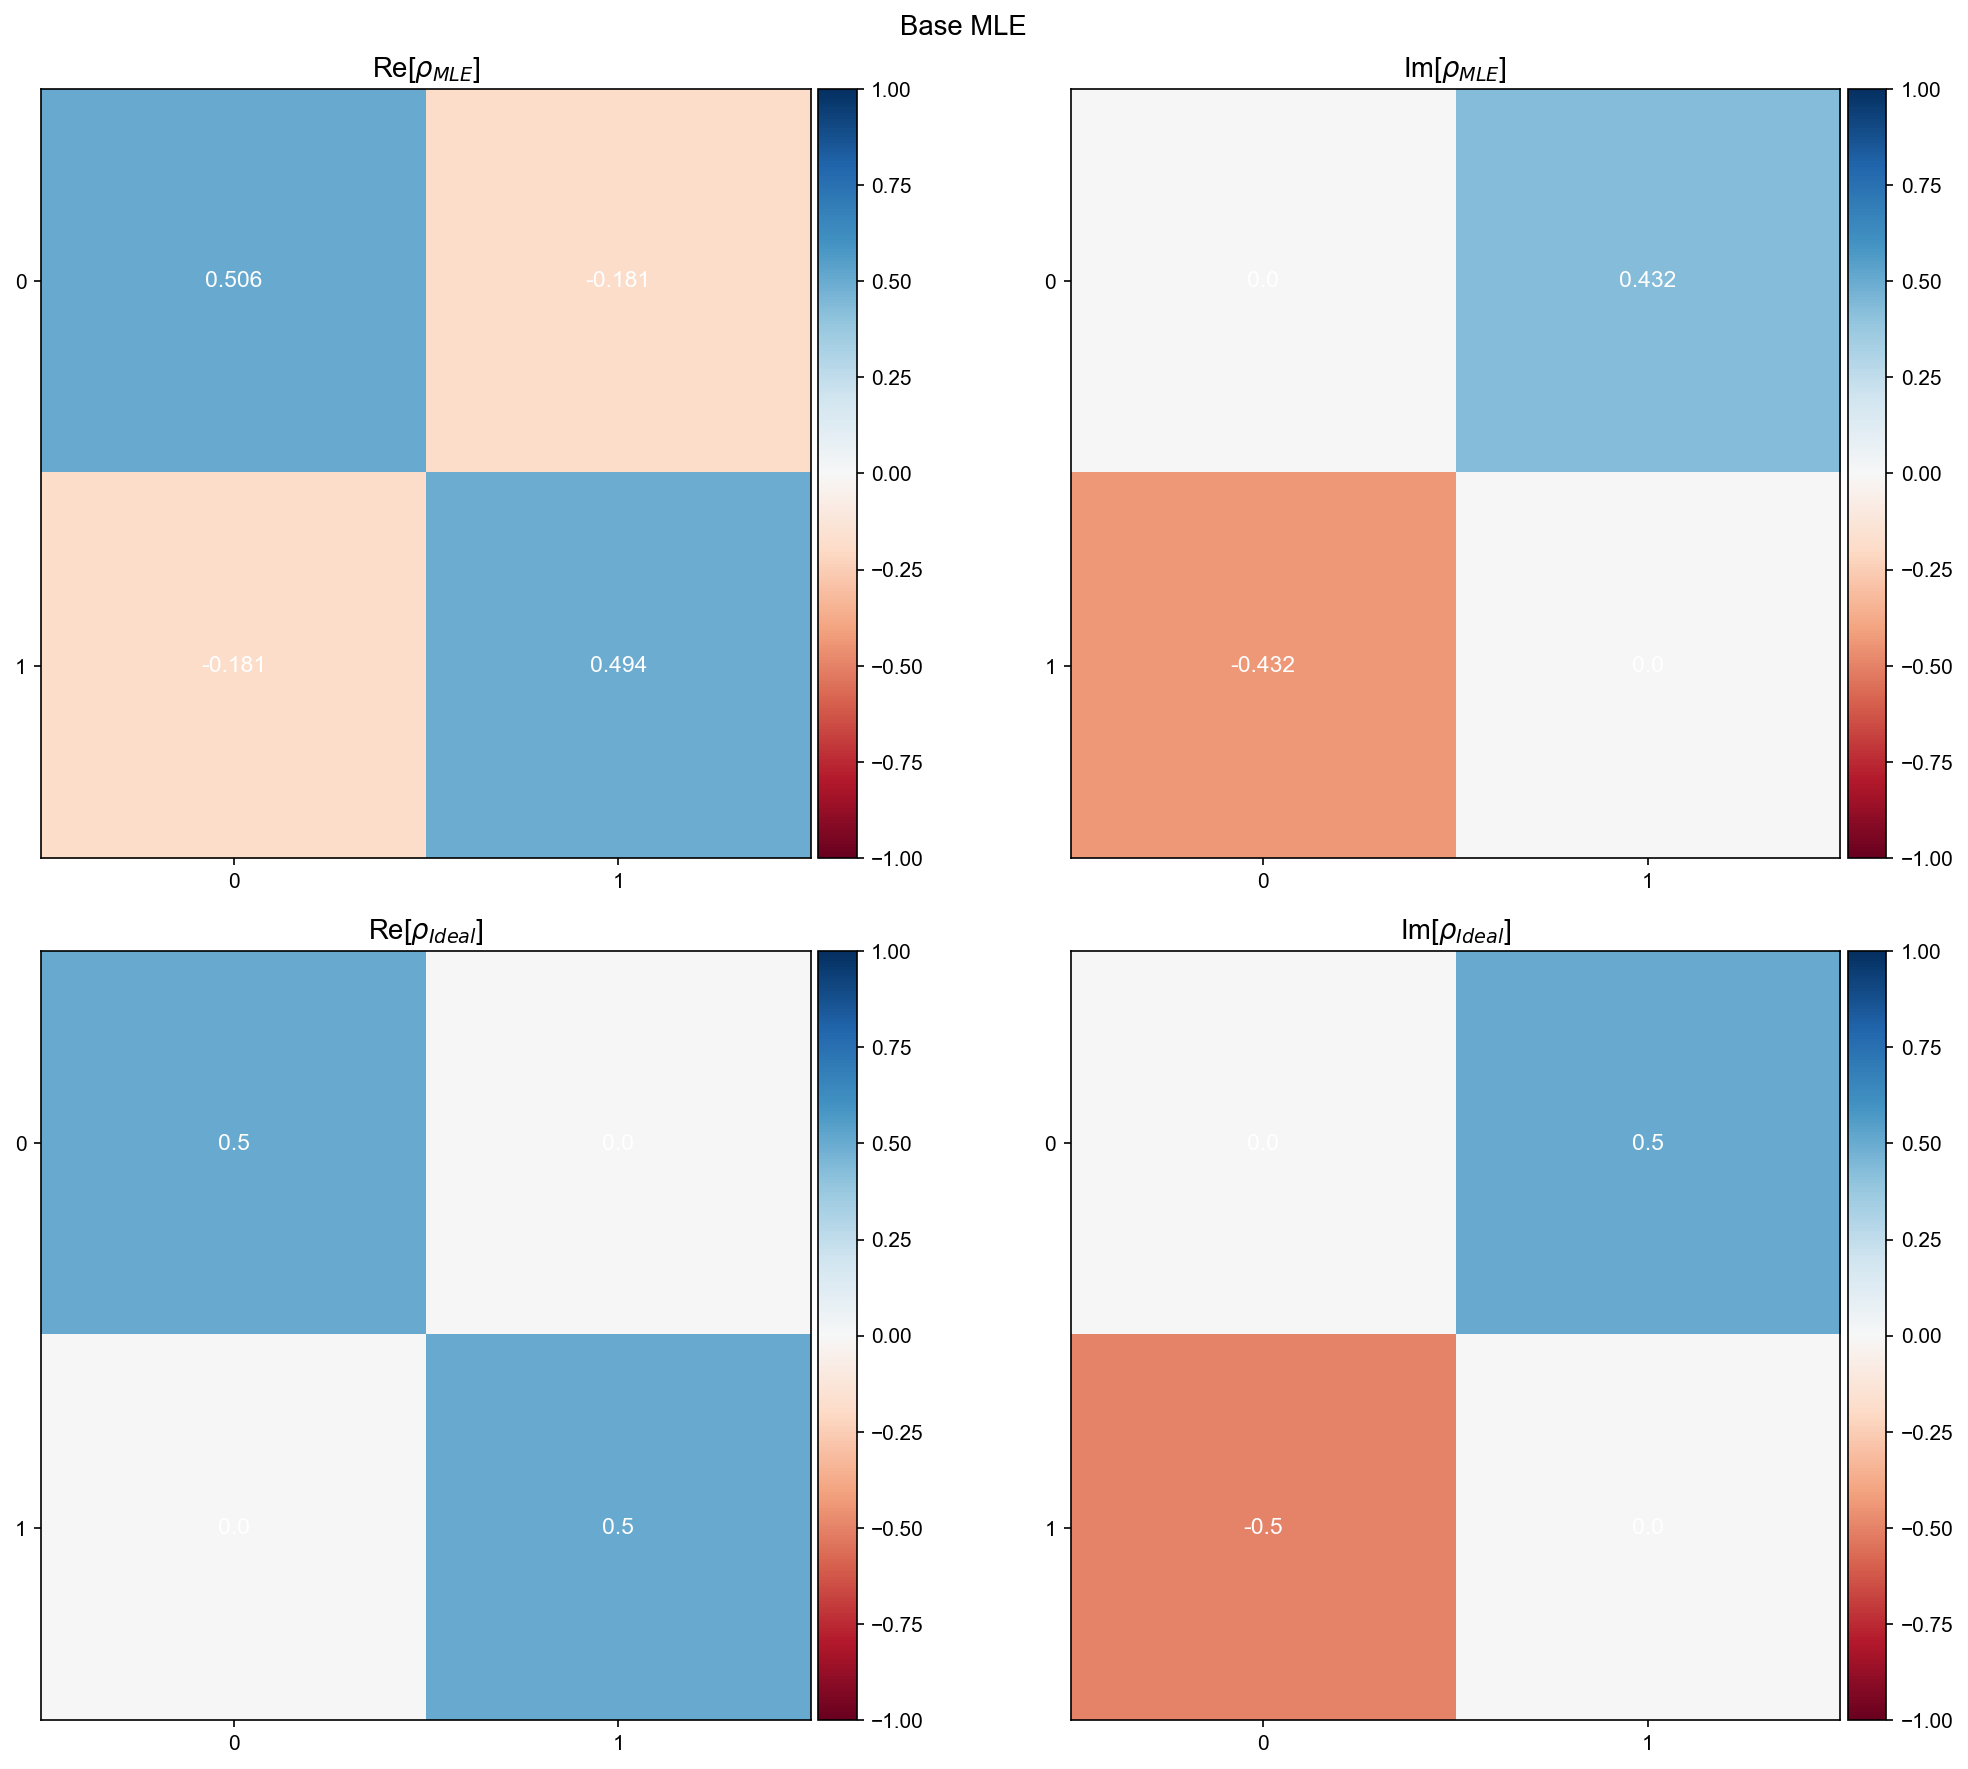

In [138]:
show_plot_rho_2d(rho_MLE, rho_id, title='Base MLE')